In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Check if a GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%pip install einops
from einops import rearrange

Note: you may need to restart the kernel to use updated packages.


dog.jpg exists
torch.Size([3, 1365, 2048])


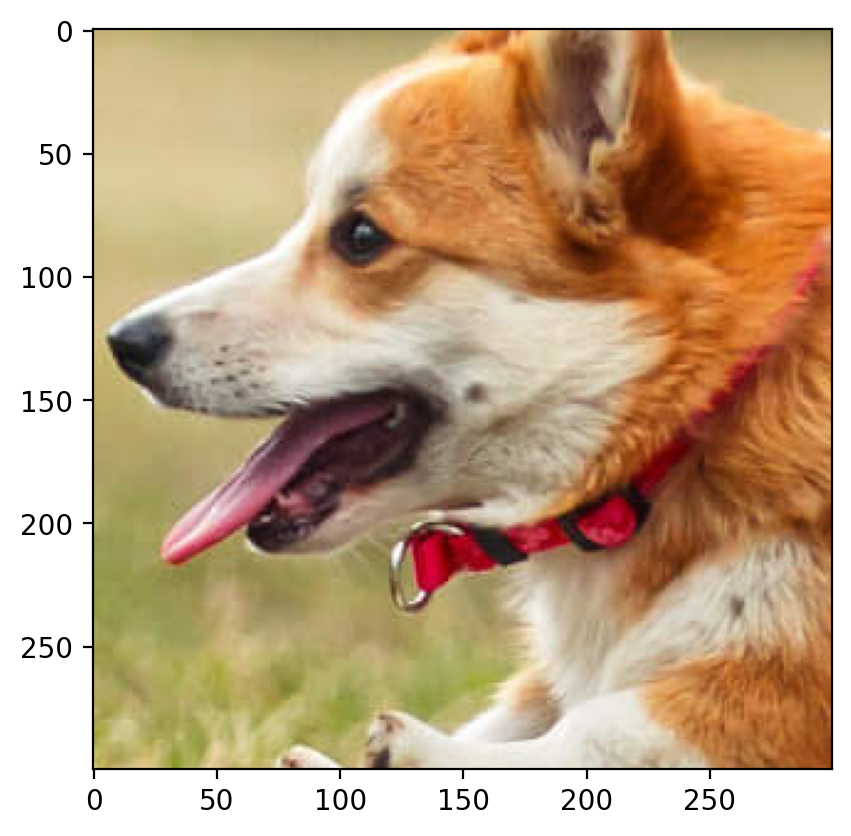

In [2]:

import os
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

import torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)



def extract_patches(img,top_left,hight,width):
    x,y = top_left
    patches = torchvision.transforms.functional.crop(img,y,x,hight,width)
    return patches

dog = extract_patches(img,(800,600),300,300)
plt.imshow(dog.permute(1,2,0).numpy().astype('uint8'))

def img_missing_patches(img,top_left,hight,width):
    y,x = top_left
    patches = extract_patches(img,top_left,hight,width)
    patches_copy = patches.clone().float()
    mask = torch.rand(patches.shape) <= 1
    patches_copy[mask] = float('nan')
    img_copy = img.clone().float()
    img_copy[:,x:x+width,y:y+hight] = patches_copy
    return img_copy,patches,patches_copy


def factorize(A, k,device=torch.device("cpu"), max_iter = 10000,convergence_threshold = 1e-6,lambda_reg=0.1):
    """Factorize the matrix A into two matrices W and H."""
    A = A.to(device)
    lst = []
    for i in range(3):
       
        # Randomly initialize matrices W and H
        W_r = torch.randn(A[i].shape[1], k, requires_grad=True, device=device)
        H_r = torch.randn(k, A[i].shape[1], requires_grad=True, device=device)
        # Adam optimizer
        optimizer = optim.Adam([W_r, H_r], lr=0.01)
        mask = ~torch.isnan(A[i])
        prev_loss = float('inf')
        for iteration in range(max_iter):
        
            # Compute the loss
            #print(torch.matmul(W_r, H_r).shape)
            diff_matrix = torch.matmul(W_r, H_r) - A[i]
            diff_vector = diff_matrix[mask]
            regularization = lambda_reg * (torch.norm(W_r) + torch.norm(H_r))
            loss = torch.norm(diff_vector)+ regularization

            if iteration > 0 and abs(prev_loss - loss.item()) < convergence_threshold:
                print(f'Converged after {iteration} iterations')
                break
            # Zero the gradients
            optimizer.zero_grad()
        
            # Backpropagate
            loss.backward()
        
            # Update the parameters
            optimizer.step()
            prev_loss = loss.item()
        
        lst.append(torch.clone(torch.matmul(W_r, H_r).detach()))
        #print(lst[i].shape)

    A_re = torch.stack([lst[0],lst[1],lst[2]], dim=0)
        
    #print(A_re)
    return A_re


In [3]:
# Function to complete the missing patch
def complete_missing_patch(img, top_left, height, width, k,method="GD"):
    """Complete the missing rectangular patch in the image."""
    # Extract the patches surrounding the missing patch
    x, y = top_left
    img,patch,patch_copy = img_missing_patches(img,top_left,height,width)
    # Factorize the image matrix
    if(method=="GD"):
        img_re = factorize(img, k)
    # else:
    #     img_re = LS_factorize
    # Reconstruct the missing patch using factorized matrices
   
    
    
    return img,img_re,patch

In [6]:
import os
import matplotlib.pyplot as plt

def save_figure(patche,img, completed_img, name, folder="figures"):
    """Save the original and completed images as figures."""
    Create the directory to store figures if it doesn't exist
    if not os.path.exists(folder):
        os.makedirs(folder)

    # Plot both the original image and the completed image simultaneously
    plt.figure(figsize=(18, 6))  # Adjust the size as needed
    plt.subplot(1, 3, 1)
    plt.imshow((patche/255).permute(1, 2, 0).numpy())
    plt.title('Missing Patch')
    
    plt.subplot(1, 3, 2)
    plt.imshow((img/255).permute(1, 2, 0).numpy())
    plt.title('Original Image')

    plt.subplot(1, 3, 3)
    plt.imshow((completed_img/255).detach().permute(1, 2, 0).numpy())
    plt.title('Reconstructed Image')
   
    # Save the figure with the specified name in the folder
    plt.savefig(os.path.join(folder, f"{name}.png"))
    plt.show()
    plt.close()


def img_const(img,top_left,hight,width,k,name,method="GD"):
    img, re_img, patch = complete_missing_patch(img,top_left, hight, width, k)
    save_figure(patch,img, re_img, name)
    return img, re_img
# Example usage
# Assuming 'img' and 'completed_img' are the original and completed images, respectively
# and 'dog' is your image tensor
# img_const_LS(dog, (0,0), 30, 30, 70, 'Single_color_patch_missing')

SyntaxError: unterminated string literal (detected at line 6) (631907500.py, line 6)

#
#
#

In [7]:
img,_,_ = img_missing_patches(dog,(50,50),30,30)
a=factorize(img, 50)
b=factorize(img, 200)

Converged after 4176 iterations
Converged after 3762 iterations
Converged after 4275 iterations


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.953431..1.8623935].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00540435..1.0472603].


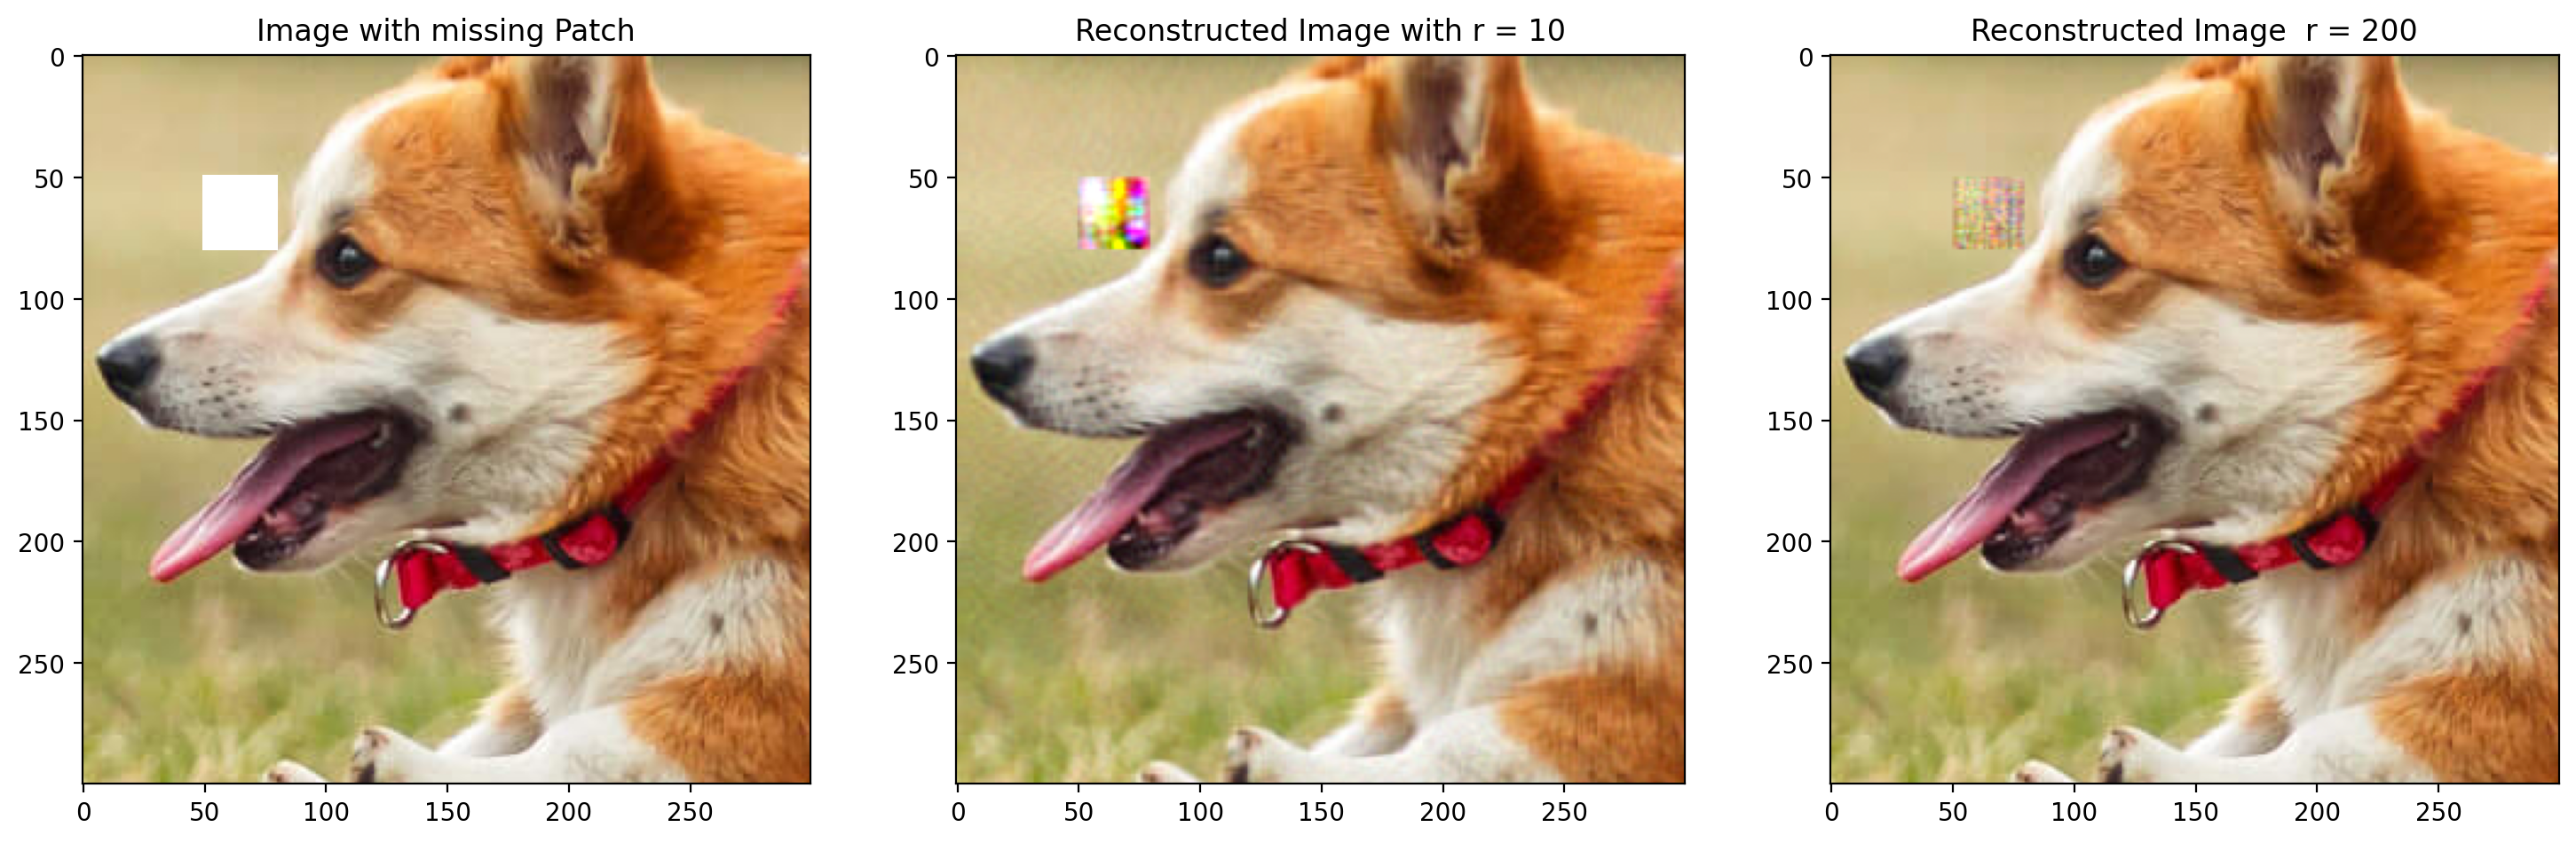

In [8]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1, 3, 1)
plt.imshow((img/255).permute(1, 2, 0).numpy())
plt.title('Image with missing Patch')

plt.subplot(1, 3, 2)
plt.imshow((a/255).permute(1, 2, 0).numpy())
plt.title('Reconstructed Image with r = 10')

plt.subplot(1, 3, 3)
plt.imshow((b/255).detach().permute(1, 2, 0).numpy())
plt.title('Reconstructed Image  r = 200')

plt.show()
plt.close()

In [17]:
def calRMSE_and_PSNR(img1,img2):
    """
    img1: torch.Tensor of shape (num_channels, height, width)
    img2: torch.Tensor of shape (num_channels, height, width)

    return: tuple of float and float
    """
    rmse = torch.sqrt(torch.mean((img1 - img2) ** 2))
    psnr = 20 * torch.log10(1.0 / rmse)
    return rmse.item(), psnr.item()

rmse, psnr = calRMSE_and_PSNR(dog/255, b/255)
print(f" RMSE for sigma = {0.1} ", rmse, f" \nPSNR for sigma = {0.1} ", psnr)

 RMSE for sigma = 0.1  0.010562915354967117  
PSNR for sigma = 0.1  39.524322509765625


#
#
#
#
#
#

In [18]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

 
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float()


    X = X.to(device)

 
    Y = rearrange(img, 'c h w -> (h w) c').float()

    # Move X to GPU if available
    Y = Y.to(device)

    return X, Y



def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


def crop_img(img,top_left,hight,width):
    x,y = top_left
    crop = torchvision.transforms.functional.crop(img,y,x,hight,width)
    return crop


def create_img_missing_patches(img,top_left,hight,width):
    """
    Create a missing patch in the image

    Inputs:
        img : torch.Tensor of shape (num_channels, height, width) where you want to create a missing patch
        top_left : tuple of (x,y) coordinates of the top left corner from where the patch should be removed
        hight : hight of the patch that should be removed
        width : width of the patch that should be removed

    Returns:
        missing_patch_img : torch.Tensor of shape (num_channels, height, width) --> full image with the missing patch
        crop : torch.Tensor of shape (num_channels, hight, width) --> missing patch
    """
    y,x = top_left
    crop = crop_img(img,top_left,hight,width)
    crop_copy = crop.clone().float()
    mask = torch.rand(crop.shape) <= 1
    crop_copy[mask] = float('nan')
    missing_patch_img = img.clone().float()
    missing_patch_img[:,x:x+width,y:y+hight] = crop_copy
    return missing_patch_img,crop

def create_patch_features(img,top_left,hight,width,num_features,sigma):
    """
    create a missing patch in the image and create the RFF features

    inputs:
        img : torch.Tensor of shape (num_channels, height, width) where you want to create a missing patch
        top_left : tuple of (x,y) coordinates of the top left corner from where the patch should be removed
        hight : hight of the patch that should be removed
        width : width of the patch that should be removed
        num_features : number of features to be created
        sigma : sigma for the RFF

    Returns:
        missing_patch_img : torch.Tensor of shape (num_channels, height, width) --> full image with the missing patch
        dog_X_scaled : torch.Tensor of shape (height * width, 2) --> coordinate map
        dog_Y : torch.Tensor of shape (height * width, num_channels) --> image map
        X_rff : torch.Tensor of shape (height * width, num_features) --> RFF features

    """

    missing_patch_img,crop = create_img_missing_patches(img,top_left,hight,width)

    dog_X,dog_Y = create_coordinate_map(img,scale=1)
    scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
    dog_X_scaled = scaler_X.transform(dog_X.cpu())
    dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
    dog_X_scaled = dog_X_scaled.float()

    X_rff = create_rff_features(dog_X_scaled, num_features, sigma)
    return missing_patch_img,dog_X_scaled,dog_Y,X_rff


def create_training_data(X_rff,Y,top_left,hight,len_img):
    """
    create the training data for the missing patch
    inputs:
        X_rff : torch.Tensor of shape (height * width, num_features) --> contains the RFF features for whole image
        Y : torch.Tensor of shape (height * width, num_channels) --> contains the image map for whole image
        top_left : tuple of (x,y) coordinates of the top left corner from where the patch should be removed
        hight : hight of the patch that should be removed
        len_img : width of the entire image

    Returns:
        X_train : torch.Tensor of shape (height * width, num_features) --> contains the RFF features excluding the missing patch
        Y_train : torch.Tensor of shape (height * width, num_channels) --> contains the image map excluding the missing patch
    """
    x,y = top_left
    mask = np.array([True for _ in range(len(X_rff))])
    for i in range(hight):
       mask[x*len_img +y +i:x*len_img +y +i + hight] = False
    X_train = X_rff[::1][mask]
    Y_train = Y[::1][mask]
    return X_train,Y_train




class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss.item()


def plot_reconstructed_and_original_image(original_img, net, X, title="", folder='figures',scale=1):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    if not os.path.exists(folder):
        os.makedirs(folder)
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height*scale, width*scale, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    plt.savefig(os.path.join(folder, f"{title}.png"))  # Corrected folder path here
    plt.show()
    plt.close()
    return outputs



def mask_image(img, width, height):
    img_copy = img.clone().float()
    shape = img.shape

    # Generate random indices for masking
    mask_indices = torch.randperm(shape[1] * shape[2])[:width * height]

    # Convert indices to 2D coordinates
    mask_indices_2d = torch.unravel_index(mask_indices, (shape[1], shape[2]))

    # Create a mask
    mask = torch.zeros((shape[1], shape[2]), dtype=torch.bool)
    mask[mask_indices_2d] = True

    # Apply the mask to the image
    for i in range(shape[0]):
        img_copy[i][mask] = float('nan')

    return img_copy, mask




In [ ]:
img,dog_X,dog_Y,X_rff = create_patch_features(dog,(50,50),30,30,10000,0.05)
X_train,Y_train = create_training_data(X_rff,dog_Y,(0,0),30,30)
net = LinearModel(X_train.shape[1], Y_train.shape[1]).to(device)
train(net, 0.01, X_train, Y_train, 500) 

Epoch 0 loss: 24180.958984
Epoch 100 loss: 23356.337891
Epoch 200 loss: 22573.417969
Epoch 300 loss: 21827.890625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-17.93452..31.510246].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


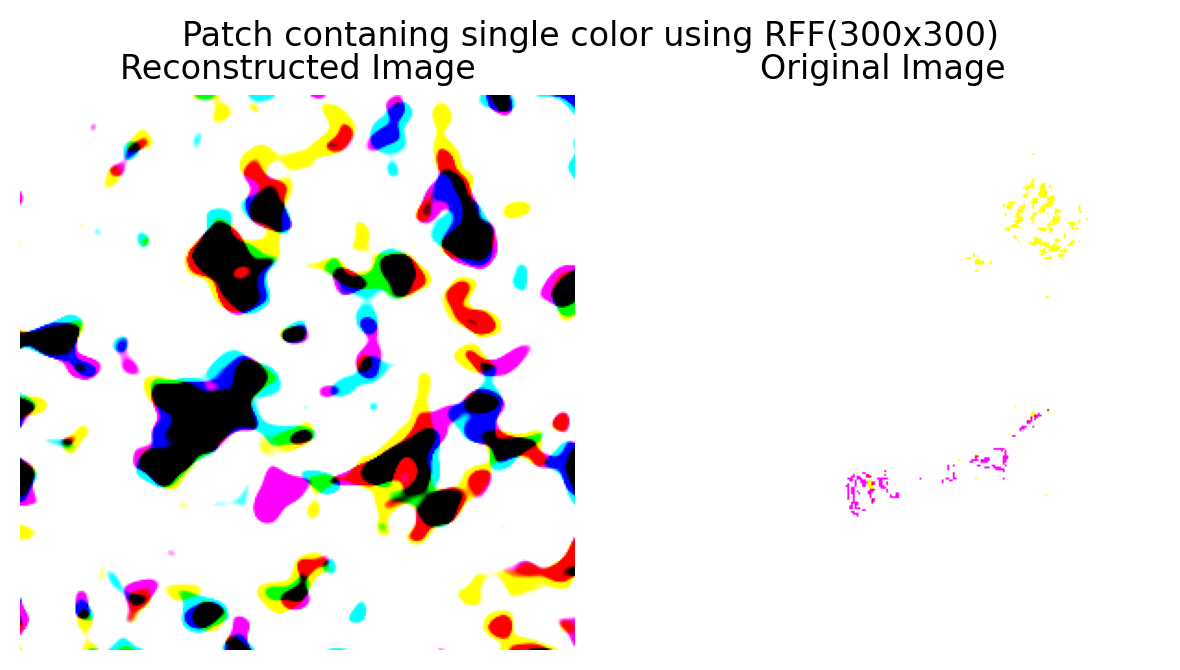

In [27]:
import matplotlib.gridspec as gridspec

output1 = plot_reconstructed_and_original_image(img, net, X_rff, title="Patch contaning single color using RFF(300x300)", folder='figures',scale=1)
